# COVID-19 Detection in Chest X-Ray Images
The goal of this project is to build a model that identifies COVID-19, pneumonia in chest X-Ray images. The dataset is organized into 3 folders (COVID-19 cases, Normal , Pneumonia) and contains subfolders for each image category. There are 606 X-Ray images (JPEG). Data from [Mendeley](https://data.mendeley.com/datasets/fvk7h5dg2p/1). 

In [3]:
# Load necesary libararies
import os
from shutil import copyfile, rmtree
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Libraries for Convolutoinal Neural Network
from tensorflow.keras import models, layers, losses, preprocessing, optimizers, callbacks, regularizers
from tensorflow.keras.applications.resnet50 import ResNet50

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import cv2
from keras_visualizer import visualizer

D:\Anaconda3\envs\ml_env\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\envs\ml_env\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\envs\ml_env\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\envs\ml_env\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

Before we start, I'm going to rename all the images to match their label. This will just help us identify which images are which later on, in case we need to compare filenames.

In [4]:
# Root path to image library
dataroot = "dataroot/"

In [5]:
path_covid = os.path.join(dataroot, 'COVID-19 cases')
path_normal = os.path.join(dataroot, 'Normal')
path_pneumonia = os.path.join(dataroot, 'Pneumonia')

# Rename each image in the directories to match the label of the image.
def rename_imgs(path, label):
    for count, filename in enumerate(os.listdir(path)):
        # Rename all the files in directory
        filetype = filename.split(".")[-1]
        new_filename = os.path.join(path, "{}_{}.{}".format(label, count, filetype))
        old_filename = os.path.join(path, filename)
        os.rename(old_filename, new_filename)

# Only rename if the folders haven't been renamed yet
if os.listdir(path_covid)[0] != "covid_0.jpeg":
    rename_imgs(path_covid, 'covid')
    rename_imgs(path_normal, 'normal')
    rename_imgs(path_pneumonia, 'pneumonia')

Now load some sample pictures to make sure the directories where created correctly, and to get a visual idea of what the different images look like.

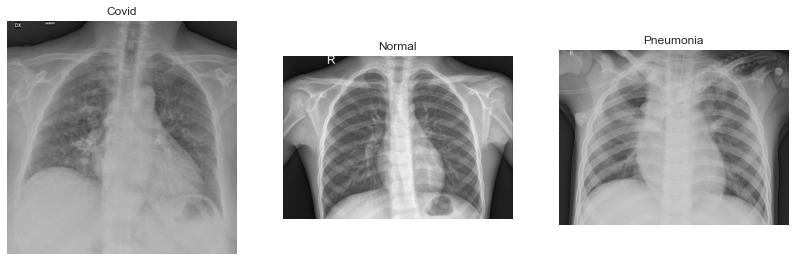

In [6]:
img_covid     = cv2.imread(os.path.join(path_covid, 'covid_1.jpeg'), 0)
img_normal    = cv2.imread(os.path.join(path_normal, 'normal_0.jpeg'), 0)
img_pneumonia = cv2.imread(os.path.join(path_pneumonia, 'pneumonia_0.jpeg'),0)

plt.figure(figsize=(14,14))
plt.subplot(1,3,1)
plt.imshow(img_covid,cmap='gray')
plt.grid(False)
plt.title("Covid")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(img_normal,cmap='gray')
plt.grid(False)
plt.title("Normal")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img_pneumonia,cmap='gray')
plt.grid(False)
plt.title("Pneumonia")
plt.axis('off');

# Create training, validation and test directories

We need to start by reorganizing our data directories. We will eventually need to use Keras to load a training, validation and test set, so we will need to split our data into training, validation and test folders. Let's do that first, before loading anything.

In [91]:
# # Cell to delete train, validation and test folders
# check = input("Are you sure you want to delete the training, validation and test directories? Enter 'y' if yes.")
# if check=='y':
#     rmtree(os.path.join(dataroot, "train"))
#     rmtree(os.path.join(dataroot, "valid"))
#     rmtree(os.path.join(dataroot, "test"))

In [92]:
def create_train_valid_test_dir(dataroot, source_dir, label, test_size=0.2, valid_size=0.2):
    # Randomly assign each file to train, valid or test
    files = os.listdir(source_dir)
    test_files = np.random.choice(files, int(len(files)*test_size))
    train_files = [file for file in files if file not in test_files]
    valid_files = np.random.choice(train_files, int(len(train_files)*valid_size))
    train_files = [file for file in train_files if file not in valid_files]
    
    # Copy each file from the original directory to the assigned directory
    path_train = os.path.join(dataroot, "train", label)
    path_valid = os.path.join(dataroot, "valid", label)
    path_test = os.path.join(dataroot, "test", label)

    # Make the directories
    os.mkdir(path_train)
    os.mkdir(path_valid)
    os.mkdir(path_test)
    
    # Copy all the files from the original directory to the new directory
    for file in test_files:
        src_file = os.path.join(source_dir, file)
        dst_file = os.path.join(path_test, file)
        copyfile(src_file, dst_file)
    for file in valid_files:
        src_file = os.path.join(source_dir, file)
        dst_file = os.path.join(path_valid, file)
        copyfile(src_file, dst_file)
    for file in train_files:
        src_file = os.path.join(source_dir, file)
        dst_file = os.path.join(path_train, file)
        copyfile(src_file, dst_file)
        
if not os.path.isdir(os.path.join(dataroot, "train")):
    os.mkdir(os.path.join(dataroot, "train"))
    os.mkdir(os.path.join(dataroot, "valid"))
    os.mkdir(os.path.join(dataroot, "test"))
if not os.path.isdir(os.path.join(dataroot, "train", "normal")):
    create_train_valid_test_dir(dataroot, path_normal, "normal")
if not os.path.isdir(os.path.join(dataroot, "train", "covid")):
    create_train_valid_test_dir(dataroot, path_covid, "covid")
if not os.path.isdir(os.path.join(dataroot, "train", "pneumonia")):
    create_train_valid_test_dir(dataroot, path_pneumonia, "pneumonia")

# Create a dataframe of Images

In order to visualize our data, we're going to load them into pandas DataFrames. Load them below.

In [37]:
# Create DataFrames of each image directory
def imgs_to_df(directory):
    data = []
    for filename in os.listdir(directory):
        # Load the image as a matrix of pixels (greyscale)
        path = os.path.join(directory, filename)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        # Store image and label in a list
        data.append([filename, img, path.split("_")[0].split('\\')[1]])
    # Convert list to a dataframe
    df = pd.DataFrame(data, columns=["filename", "img", "label"])
    # Convert label to categorical
    df["label"] = df["label"].astype("category")
    return(df)
        
# Load all images in a directory into a pandas dataframe
df_covid = imgs_to_df(path_covid)
df_normal = imgs_to_df(path_normal)
df_pneumonia = imgs_to_df(path_pneumonia)

In [38]:
df_covid.head()

,filename,img,label
0,covid_0.jpeg,"[[182, 169, 152, 142, 140, 142, 140, 137, 138,...",covid
1,covid_1.jpeg,"[[52, 52, 52, 51, 51, 52, 52, 52, 51, 51, 51, ...",covid
2,covid_10.png,"[[6, 6, 6, 6, 7, 7, 7, 7, 6, 6, 7, 7, 7, 7, 7,...",covid
3,covid_100.png,"[[17, 10, 7, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",covid
4,covid_101.png,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",covid


# Create training and test dataframes

In [39]:
# Split each subDataFrame into training and test sets
def get_train_valid_test_df(df, test_size=0.2, valid_size=0.1):
    x_train, x_test, y_train, y_test = train_test_split(df.drop("label", axis=1),
                                                        df["label"],
                                                        test_size=test_size,
                                                        random_state=42)
    x_train, x_valid, y_train, y_valid = train_test_split(x_train,
                                                          y_train,
                                                          test_size=valid_size,
                                                          random_state=42)
    return(x_train, x_valid, x_test, y_train, y_valid, y_test)



x_train_covid, x_test_covid, y_train_covid, y_test_covid = train_test_split(df_covid.drop("label", axis=1), 
                                                                            df_covid["label"],
                                                                            test_size=0.2,
                                                                            random_state=42)
x_train_normal, x_test_normal, y_train_normal, y_test_normal = train_test_split(df_normal.drop("label", axis=1), 
                                                                                df_normal["label"],
                                                                                test_size=0.2,
                                                                                random_state=42)
x_train_pneu, x_test_pneu, y_train_pneu, y_test_pneu = train_test_split(df_pneumonia.drop("label", axis=1), 
                                                                        df_pneumonia["label"],
                                                                        test_size=0.2,
                                                                        random_state=42)
# Split the training data into training and validation dataframes

# Combine into a training and test set
x_train = pd.concat([x_train_normal, x_train_covid, x_train_pneu])
y_train = pd.concat([y_train_normal, y_train_covid, y_train_pneu])
x_test = pd.concat([x_test_normal, x_test_covid, x_test_pneu])
y_test = pd.concat([y_test_normal, y_test_covid, y_test_pneu])

x_train["label"] = y_train
x_test["label"] = y_test

# Save the training and test sets as directories
path_train = os.path.join(dataroot, "train")
path_test = os.path.join(dataroot, "test")

In [117]:
if not os.path.isdir(path_train):
    os.mkdir(path_train)
    x_train.apply(lambda x: cv2.imwrite(os.path.join(path_train, x["filename"]), x["img"]), axis=1)
if not os.path.isdir(path_test):
    os.mkdir(path_test)
    x_test.apply(lambda x: cv2.imwrite(os.path.join(path_test, x["filename"]), x["img"]), axis=1)

Now we can load images directly from our training and test directories

# Data Exploration and Cleaning

Text(0.5, 1.0, 'Histogram of Label Counts')

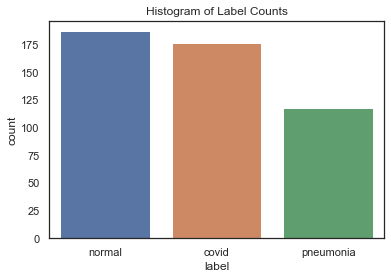

In [118]:
# Visualize the counts of labels
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.countplot(x=y_train, ax=ax)
ax.set_title("Histogram of Label Counts")

We will eventually build a CNN, so to make the input easier on the model, we will want to reshape all of our images to the same shape. But that will depend on the data, so how do we pick that size? There isn't a single answer to the that question. Let's take a look at the existing picture sizes, to get an idea of what image size would fit our data.

Text(0.5, 1.0, 'Image Sizes Per Class')

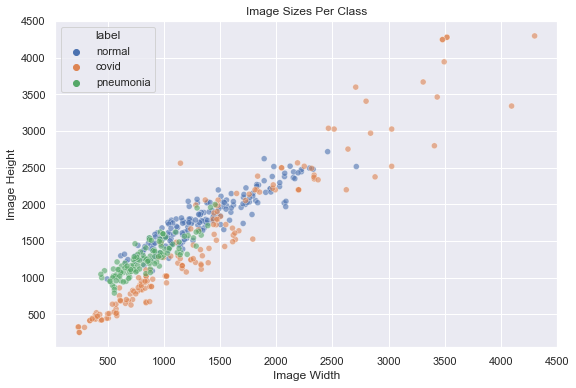

In [40]:
# Scatterplot of different image sizes
x_train["width"] = x_train["img"].apply(lambda x: x.shape[0])
x_train["height"] = x_train["img"].apply(lambda x: x.shape[1])
x_train["aspect ratio"] = x_train["width"] / x_train["height"]

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
sns.scatterplot(data=x_train, x="width", y="height", hue=y_train, alpha=0.6, ax=ax)
ax.set_xlabel("Image Width")
ax.set_ylabel("Image Height")
ax.set_title("Image Sizes Per Class")

Text(0.5, 1.0, 'Histogram of Aspect Ratios')

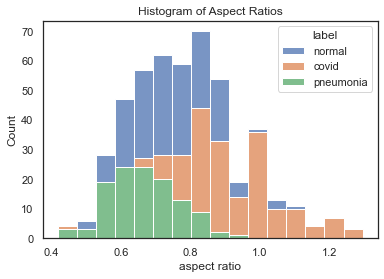

In [120]:
# Plot the aspect ratios of the pictures
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.histplot(data=x_train, x="aspect ratio", hue=y_train, multiple="stack", ax=ax)
ax.set_title("Histogram of Aspect Ratios")

I'm going to use a size of $224 \times 224$ because, later on we will use a transfer learning network, and that network has already been trained on images of that size.

We will also do some image augmentation to artificially increase the size of the training set. This means that each training image will be slightly altered before it is sent to the model. Here is a quick example of what image augmentation looks like.

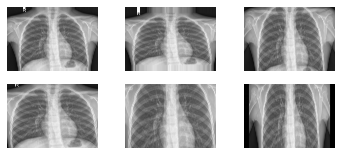

In [180]:
# example of horizontal shift image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# load the image
img = load_img(os.path.join(dataroot, 'normal', 'normal_0.jpeg'))
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = preprocessing.image.ImageDataGenerator(zoom_range=[0.5, 1.5])
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(6):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    plt.grid(False)
    plt.axis("off")
    plt.imshow(image)
# show the figure
plt.show()

# Fit the CNN

Define a CNN base using a common pattern of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers. A Keras CNN takes tensors of shape (image width, image height, channels) as input, and outputs tensors of the same shape. I.e. the tensors are three dimensional. Normally, there would be 3 channels for the RGB colors of an image. Because all of our images are greyscale, we only need one channel.

In [118]:
# Create the base of the CNN model
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3,3)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

In [119]:
# Check the CNN's architecture
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 222, 222, 32)      320       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 108, 108, 32)      18464     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 54, 54, 32)        0         
Total params: 37,280
Trainable params: 37,280
Non-trainable params: 0
_________________________________________________________________


To complete the model, we will need to feed the last output tensor from the CNN into a Dense layer that will perform the classification. Remember that we have 3 different classes, so the output of that layer will be 3. However, a Dense layer can only take a 1-dimensional tensor as input, so we will need to flatten the 3D output of the Conv2D layer into a 1D vector.

In [120]:
model.add(layers.Flatten())
# model.add(layers.Dense(8192, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
# A final decision layer
model.add(layers.Dense(3, activation='softmax'))

In [213]:
# Check the full architecture
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 222, 222, 32)      320       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 108, 108, 32)      18464     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 93312)             0         
_________________________________________________________________
dense_31 (Dense)             (None, 64)               

Now it's time to compile and train our model. But before we do that, we need to load our data in a way that Keras will be able to use. We can use the `ImageDataGenerator` class to do this. We can also use this class to augment or images. What does that mean, and why are we doing it? Neural Networks require a lot of data to train correctly, and we don't have that many images. With only 603 total, and only about 400 being used for our training set, we are going to run out of new training data very quickly. So we can use an augmenter to slightly change each training image, such as zooming or rotating, which will result in images that are still within the same class, but different enough to allow the model to keep learning. This is essentially artificially increasing the number of images in our training set. We don't want to do this to the validation or test sets, becaue we want to check if the model is correctly classifying those images. Slightly changing the images wouldn't necesarily facilitate better classifications.

In [7]:
# Define a generator to load batches of image data from the training set
train_datagen = preprocessing.image.ImageDataGenerator(rescale=1.0/255,
                                                       rotation_range=40,
                                                       width_shift_range=0.2,
                                                       height_shift_range=0.2,
                                                       shear_range=0.2,
                                                       zoom_range=[0.8, 1.2],
                                                       brightness_range=[0.5, 1.5],
                                                       horizontal_flip=True,
                                                       fill_mode='nearest')
path_train = os.path.join(dataroot, "train")
train_generator = train_datagen.flow_from_directory(path_train,
                                                    target_size=(224, 224),
                                                    color_mode="grayscale",
                                                    batch_size=20,
                                                    seed=42)

# Define another to laod batches from the validation set
validation_datagen = preprocessing.image.ImageDataGenerator(rescale=1.0/255)
path_valid = os.path.join(dataroot, "valid")
validation_generator = validation_datagen.flow_from_directory(path_valid, 
                                                              target_size=(224, 224), 
                                                              color_mode="grayscale",
                                                              batch_size=20,
                                                              seed=42)

# Load the test data
test_datagen = preprocessing.image.ImageDataGenerator(rescale=1.0/255)
path_test = os.path.join(dataroot, "test")
test_generator = train_datagen.flow_from_directory(path_test,
                                                   target_size=(224, 224),
                                                   color_mode="grayscale",
                                                   shuffle=False,
                                                   batch_size=20,
                                                   seed=42)

Found 408 images belonging to 3 classes.
Found 87 images belonging to 3 classes.
Found 108 images belonging to 3 classes.


In [8]:
# Define some conditions to reduce the chance of overfitting.
# Define an early stopping condition.
earlystop = callbacks.EarlyStopping(monitor="val_loss", 
                                    patience=10)
# Define a callback to reduce the learning rate once the model has stopped improving
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                        factor=0.1,
                                        patience=5,
                                        verbose=1)

In [141]:
# Compile our model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

# Fit the model to the training data
history = model.fit(train_generator,
                    epochs=40,
                    callbacks=[earlystop, reduce_lr],
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/20
21/21 [==============================] - 302s 14s/step - loss: 1.1817 - acc: 0.3627 - val_loss: 1.2043 - val_acc: 0.3563
Epoch 2/20
21/21 [==============================] - 273s 13s/step - loss: 1.1563 - acc: 0.3922 - val_loss: 1.2043 - val_acc: 0.3563
Epoch 3/20
21/21 [==============================] - 274s 13s/step - loss: 1.1632 - acc: 0.3922 - val_loss: 1.1857 - val_acc: 0.3563
Epoch 4/20
21/21 [==============================] - 273s 13s/step - loss: 1.1563 - acc: 0.3922 - val_loss: 1.2229 - val_acc: 0.3563
Epoch 5/20
21/21 [==============================] - 273s 13s/step - loss: 1.1598 - acc: 0.3922 - val_loss: 1.2043 - val_acc: 0.3563
Epoch 6/20
21/21 [==============================] - 273s 13s/step - loss: 1.1632 - acc: 0.3922 - val_loss: 1.1672 - val_acc: 0.3563
Epoch 7/20
21/21 [==============================] - 270s 13s/step - loss: 1.1529 - acc: 0.3922 - val_loss: 1.2043 - val_acc: 0.3563
Epoch 8/20
21/21 [==============================] - 269s 13s/step - loss: 1.

In [ ]:
# Save the model and history so we don't have to build it again
model.save("covid_xray")
    
# Load the model and history if we don't want to retrain everything
# model = models.load_model("covid_xray")

We've finally built our CNN and trained in to our data! Let's take a look at how the model's accuracy changed over time. 

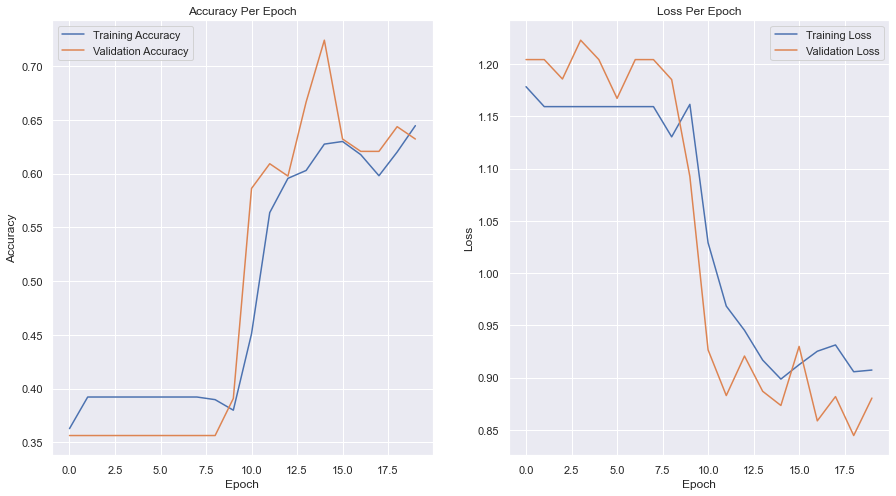

In [142]:
# Plot the training and validation loss and accuracy

fig, ax = plt.subplots(1, 2, figsize=(15, 8))

ax[0].plot(history.history["acc"], label="Training Accuracy")
ax[0].plot(history.history["val_acc"], label="Validation Accuracy")
ax[0].set_title("Accuracy Per Epoch")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].legend()

ax[1].plot(history.history["loss"], label="Training Loss")
ax[1].plot(history.history["val_loss"], label="Validation Loss")
ax[1].set_title("Loss Per Epoch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend()

In [207]:
# Accuracy on the validation set
valid_generator = validation_datagen.flow_from_directory(path_valid, 
                                                         target_size=(224, 224), 
                                                         color_mode="grayscale",
                                                         shuffle=False,
                                                         batch_size=20,
                                                         seed=42)
valid_preds = model.predict(valid_generator)
valid_preds_class = np.argmax(valid_preds, axis=1)
valid_acc = np.mean(valid_preds_class == valid_generator.labels)
valid_acc

Found 87 images belonging to 3 classes.


0.6781609195402298

Now all that's left is to see how our model performs on our test set.

In [206]:
test_preds = model.predict(test_generator)
test_preds_class = np.argmax(test_preds, axis=1)
# Calculate the accuracy of the test set
test_acc = np.mean(test_preds_class == test_generator.labels)
print("Test Accuracy: ", test_acc)

Test Accuracy:  0.6111111111111112


In [214]:
# Create a Confusion Matrix of the test results
class_dict = {0:'covid', 1:'normal', 2:'pneumonia'}
y_true = np.vectorize(class_dict.get)(test_generator.labels)
y_pred = np.vectorize(class_dict.get)(test_preds_class)

conf = confusion_matrix(y_true, y_pred, labels=list(class_dict.values()))
conf

array([[33,  5,  0],
       [ 7, 28,  8],
       [ 6, 16,  5]], dtype=int64)

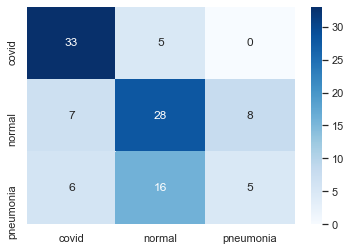

In [215]:
# Plot the confusion matrix
conf_df = pd.DataFrame(conf, list(class_dict.values()), list(class_dict.values()))
with sns.axes_style('white'):
    sns.heatmap(conf_df, annot=True, cmap="Blues")

We see that our accuracy on the test set was fairly low, about $61\%$, which is okay, but not great. Because we have 3 classes, if we had an entirely random model, then we would expect to be correct about $1/3$ of the time, but we're not going well enough for us to be confident for actual medical purposes. From the confusion matrix, we can see that the bacterial pneumonia cases are the primary ones being miscategorized.

A significant problem of our model is the training size. 400 images, even with augmentation, may not be enough to truely fit the enitrety of our model. So we can try another technique called Transfer Learning (TL), which is where we take hidden layers of a neural network trained to do task A and use that as our initial model for task B. Of course, this procedure works best whens tasks A and B are relatively similar. We're essentially giving our model a first step to start off of, then using the training set to specialize the model to our specific images.

For this case, we will use the ResNet50 model.

# Transer Learning: Feature Extraction

In [9]:
# Rebuild the training, validation and test sets with 3 color channels instead of 1
train_generator_tl = train_datagen.flow_from_directory(path_train,
                                                       target_size=(224, 224),
                                                       batch_size=20,
                                                       color_mode="rgb",
                                                       seed=42)

validation_generator_tl = validation_datagen.flow_from_directory(path_valid, 
                                                                 target_size=(224, 224), 
                                                                 batch_size=20,
                                                                 color_mode="rgb",
                                                                 seed=42)

test_generator_tl = test_datagen.flow_from_directory(path_test,
                                                     target_size=(224, 224),
                                                     batch_size=20,
                                                     shuffle=False,
                                                     color_mode="rgb",
                                                     seed=42)

Found 408 images belonging to 3 classes.
Found 87 images belonging to 3 classes.
Found 108 images belonging to 3 classes.


In [10]:
#### Load the Transfer Learning model without the final classification layer
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

output = base_model.layers[-1].output
# let's add a fully-connected layer
output = layers.Flatten()(output)
# and the final classification layer (3 classes)
# output = layers.Dense(64)(output)
# output = layers.LeakyReLU(0.05)(output)
# output = layers.Dropout(0.3)(output)
predictions = layers.Dense(3, 
                           activation='softmax', 
                           kernel_initializer='random_normal', 
                           bias_initializer='zeros',
                           kernel_regularizer=regularizers.l1(0.01))(output)
# predictions = layers.Dense(3, activation='softmax')(output)

# This is the model we will train
model_tl = models.Model(inputs=base_model.input, outputs=predictions)

# We only want to train the top layers which were randomly initialized
# I.e. Freeze all the layers from ResNet50
for layer in base_model.layers:
    layer.trainable = False

model_tl.summary()    

D:\Anaconda3\envs\ml_env\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0

In [12]:
# Compile the Model
model_tl.compile(optimizer='adam',
                 loss=losses.CategoricalCrossentropy(),
                 metrics=["accuracy"])
# Fit the model to the data
history_tl = model_tl.fit(train_generator_tl,
                          epochs=60,
                          callbacks=[earlystop, reduce_lr],
                          verbose=1,
                          validation_data=validation_generator_tl)

Epoch 1/60
21/21 [==============================] - 155s 7s/step - loss: 116.0512 - acc: 0.7402 - val_loss: 111.9352 - val_acc: 0.3908
Epoch 2/60
21/21 [==============================] - 146s 7s/step - loss: 107.3231 - acc: 0.8039 - val_loss: 102.0514 - val_acc: 0.3218
Epoch 3/60
21/21 [==============================] - 147s 7s/step - loss: 100.9714 - acc: 0.8211 - val_loss: 96.2135 - val_acc: 0.3793
Epoch 4/60
21/21 [==============================] - 151s 7s/step - loss: 94.5899 - acc: 0.8480 - val_loss: 95.5642 - val_acc: 0.3678
Epoch 5/60
21/21 [==============================] - 150s 7s/step - loss: 89.8237 - acc: 0.8431 - val_loss: 89.8316 - val_acc: 0.3908
Epoch 6/60
21/21 [==============================] - 150s 7s/step - loss: 84.2762 - acc: 0.9093 - val_loss: 84.9615 - val_acc: 0.3908
Epoch 7/60
21/21 [==============================] - 151s 7s/step - loss: 78.8246 - acc: 0.8922 - val_loss: 79.5388 - val_acc: 0.3908
Epoch 8/60
21/21 [==============================] - 99s 5s/step 

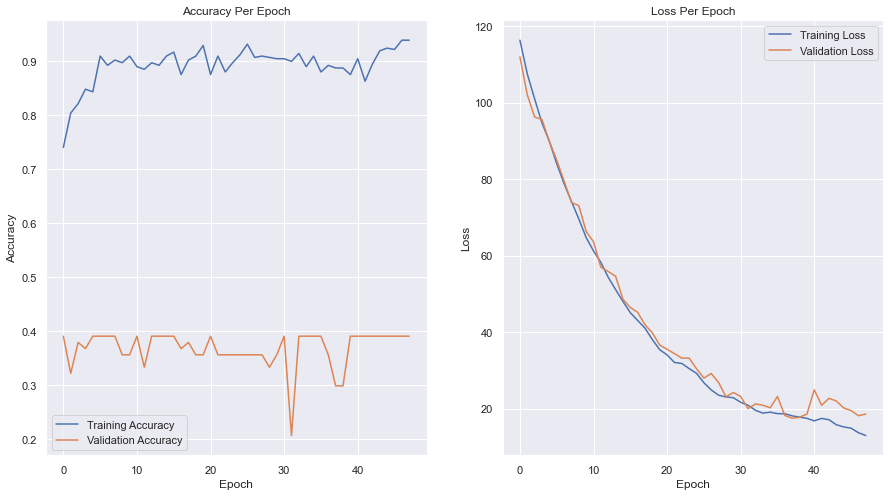

In [13]:
# Plot the training and validation loss and accuracy

fig, ax = plt.subplots(1, 2, figsize=(15, 8))

ax[0].plot(history_tl.history["acc"], label="Training Accuracy")
ax[0].plot(history_tl.history["val_acc"], label="Validation Accuracy")
ax[0].set_title("Accuracy Per Epoch")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].legend()

ax[1].plot(history_tl.history["loss"], label="Training Loss")
ax[1].plot(history_tl.history["val_loss"], label="Validation Loss")
ax[1].set_title("Loss Per Epoch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend()

In [14]:
# Accuracy on the test set
preds_tl = model_tl.predict(test_generator_tl)
preds_tl_labels = np.argmax(preds_tl, axis=1)
acc_tl = np.mean(preds_tl_labels == test_generator_tl.labels)
print(acc_tl)

0.35185185185185186


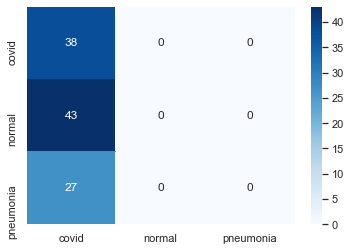

In [15]:
# Plot the confusion matrix
class_dict = {0:'covid', 1:'normal', 2:'pneumonia'}
y_true = np.vectorize(class_dict.get)(test_generator_tl.labels)
y_pred = np.vectorize(class_dict.get)(preds_tl_labels)

conf_tl = confusion_matrix(y_true, y_pred, labels=list(class_dict.values()))
conf_df = pd.DataFrame(conf_tl, list(class_dict.values()), list(class_dict.values()))
with sns.axes_style('white'):
    sns.heatmap(conf_df, annot=True, cmap="Blues")

Well, that didn't fix the problem. We could maybe unfreeze some of the last layers and do some fine tuning. This might help to 

# Transfer Learning: Fine Tuning

In [13]:
#### Load the Transfer Learning model without the final classification layer
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

output = base_model.layers[-1].output
# let's add a fully-connected layer
output = layers.Flatten()(output)

# This is the model we will train
model_fine = models.Model(inputs=base_model.input, outputs=output)

# Freeze all layers except the last 10, letting them adjust slightly to the new dataset.
# Make sure to use a low training rate to preserve the original values.
for layer in model_fine.layers[:-11]:
    layer.trainable = False

# Add trainable layers to the remaining layers
model_tl2 = models.Sequential()
model_tl2.add(model_fine)
model_tl2.add(layers.Dense(64))
model_tl2.add(layers.LeakyReLU(alpha=0.05))
model_tl2.add(layers.Dropout(0.3))
model_tl2.add(layers.Dense(3, activation='softmax'))

D:\Anaconda3\envs\ml_env\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [14]:
model_tl2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 100352)            23587712  
_________________________________________________________________
dense_2 (Dense)              (None, 64)                6422592   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 30,010,499
Trainable params: 10,888,451
Non-trainable params: 19,122,048
_________________________________________________________________


In [15]:
# Compile the Model
model_tl2.compile(optimizer=optimizers.Adam(0.0005),
                 loss=losses.CategoricalCrossentropy(),
                 metrics=["accuracy"])
# Fit the model to the data
history_model_tl2 = model_tl2.fit(train_generator_tl,
                                  epochs=40,
                                  callbacks=[earlystop, reduce_lr],
                                  verbose=1,
                                  validation_data=validation_generator_tl)

Epoch 1/40
21/21 [==============================] - 109s 5s/step - loss: 2.8369 - acc: 0.6716 - val_loss: 2.1447 - val_acc: 0.3908
Epoch 2/40
21/21 [==============================] - 103s 5s/step - loss: 0.5167 - acc: 0.8799 - val_loss: 3.4650 - val_acc: 0.3908
Epoch 3/40
21/21 [==============================] - 104s 5s/step - loss: 0.3458 - acc: 0.8725 - val_loss: 1.6292 - val_acc: 0.3908
Epoch 4/40
21/21 [==============================] - 105s 5s/step - loss: 0.4447 - acc: 0.8775 - val_loss: 1.2069 - val_acc: 0.3908
Epoch 5/40
21/21 [==============================] - 104s 5s/step - loss: 0.4532 - acc: 0.8750 - val_loss: 2.2364 - val_acc: 0.3908
Epoch 6/40
21/21 [==============================] - 104s 5s/step - loss: 0.3178 - acc: 0.9093 - val_loss: 2.5969 - val_acc: 0.3908
Epoch 7/40
21/21 [==============================] - 103s 5s/step - loss: 0.2520 - acc: 0.9191 - val_loss: 2.4166 - val_acc: 0.3908
Epoch 8/40
15/21 [====================>.........] - ETA: 26s - loss: 0.2746 - acc: 

KeyboardInterrupt: 

In [21]:
# Validation Accuracy
valid_preds_tl2 = model_tl2.predict(validation_generator_tl)
valid_preds_tl2_labels = np.argmax(valid_preds_tl2, axis=1)
valid_acc_tl2 = np.mean(valid_preds_tl2_labels == validation_generator.labels)
print(valid_acc_tl2)

0.3563218390804598


In [20]:
# Test Accuracy
test_preds_tl2 = model_tl2.predict(test_generator_tl)
test_preds_tl2_labels = np.argmax(test_preds_tl2, axis=1)
test_acc_tl2 = np.mean(test_preds_tl2_labels == test_generator.labels)
print(test_acc_tl2)

0.39814814814814814


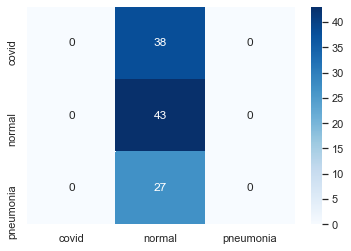

In [24]:
# Plot the confusion matrix
y_true = np.vectorize(class_dict.get)(test_generator_tl.labels)
y_pred = np.vectorize(class_dict.get)(test_preds_tl2_labels)

conf_tl = confusion_matrix(y_true, y_pred, labels=list(class_dict.values()))
conf_df = pd.DataFrame(conf_tl, list(class_dict.values()), list(class_dict.values()))
with sns.axes_style('white'):
    sns.heatmap(conf_df, annot=True, cmap="Blues")